# Building a Knowledge Graph with Small Language Models: A Comparative Approach

This notebook demonstrates the process of building a Knowledge Graph from unstructured text using small, locally-run Language Models (LLMs). We will explore two primary approaches:

1.  **The Standard LangChain Approach**: Using the built-in `LLMGraphTransformer` from LangChain. We will see the challenges and limitations, particularly the high failure rate in extracting structured graph data with smaller models like Mistral.
2.  **The BAML-Enhanced Approach**: Leveraging Boundary's AI-programming language (BAML) to significantly improve the reliability and accuracy of graph extraction from a model like Llama 3.

Finally, after successfully generating high-quality graph documents with BAML, we will ingest them into a Neo4j graph database and perform various analyses, including community detection and entity resolution, to uncover insights from the data.

In [41]:
# Magic command to load the autoreload extension.
%load_ext autoreload
# Magic command to automatically reload all modules before executing a cell.
# This is useful for development when you are changing the source code of imported modules.
%autoreload 2

### Loading and Preparing the Dataset

We will use a dataset of news articles. To manage the LLM's context window and processing time, it's crucial to understand the size of our text chunks. We'll use `tiktoken` to count the number of tokens in each article, giving us a good proxy for the input size.

                                               title  \
0                             Chevron: Best Of Breed   
1       FirstEnergy (NYSE:FE) Posts Earnings Results   
2  Dáil almost suspended after Sinn Féin TD put p...   
3  Epic’s latest tool can animate hyperrealistic ...   
4  EU to Ban Huawei, ZTE from Internal Commission...   

                                  date  \
0  2031-04-06T01:36:32.000000000+00:00   
1  2030-04-29T06:55:28.000000000+00:00   
2  2023-06-15T14:32:11.000000000+00:00   
3  2023-06-15T14:00:00.000000000+00:00   
4  2023-06-15T13:50:00.000000000+00:00   

                                                text  tokens  
0  JHVEPhoto Like many companies in the O&G secto...      78  
1  FirstEnergy (NYSE:FE – Get Rating) posted its ...     130  
2  The Dáil was almost suspended on Thursday afte...     631  
3  Today, Epic is releasing a new tool designed t...     528  
4  The European Commission is planning to ban equ...     281  


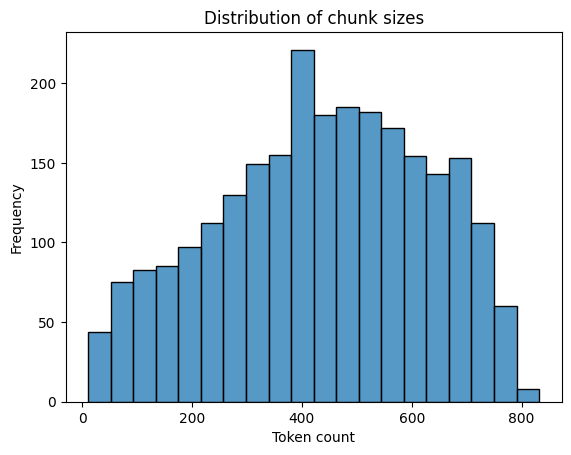

In [42]:
# Import pandas for data manipulation and tiktoken for token counting.
import pandas as pd
import tiktoken

# 定义一个函数来计算给定字符串中特定模型的令牌数
def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:  
    """返回文本字符串中的令牌数。"""  
    # 获取指定模型的编码
    encoding = tiktoken.encoding_for_model(model)  
    # 将字符串编码为令牌并计算它们  
    num_tokens = len(encoding.encode(string))  
    # 返回令牌总数
    return num_tokens  

# Load the news articles dataset from a remote CSV file.
news = pd.read_csv('./news_articles.csv')

# 在 DataFrame 中创建一个新列 'tokens'
# 计算每篇文章的 'title' 和 'text' 组合的总token数
news["tokens"] = [num_tokens_from_string(f"{row['title']} {row['text']}")    for i, row in news.iterrows() ]

print(news.head())

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of the token counts to visualize the distribution of article lengths.
sns.histplot(news["tokens"], kde=False)
plt.title("Distribution of chunk sizes")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

## Part 1:  `LLMGraphTransformer`- 基于 LLMGraphTransformer 的传统方法分析

In this section, we'll start with the standard method for graph extraction provided by LangChain. We will use `LLMGraphTransformer`, which is designed to take a sequence of documents and convert them into graph documents. We'll use the `mistral` model, a popular small LLM, to see how well this approach works out-of-the-box.

从LangChain提供的图提取的标准方法开始。我们将使用LLMGraphTransformer，它的设计目的是获取一系列文档并将它们转换为图形文档。我们将使用mistral模型，一种流行的小型LLM，来看看这种方法开箱即用的效果如何。

In [43]:
# Import necessary libraries from LangChain and other standard packages.
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_ollama import ChatOllama
import pandas as pd
from typing import List

# Import specific data structures for handling graph data.
from langchain_community.graphs.graph_document import GraphDocument, Node, Relationship
from langchain_core.documents import Document
from pydantic  import BaseModel, Field

model ="qwen3-1.7b" # "qwen3-0.6b" # "Qwen3-4b" #  "qwen_0.5b.gguf" # "deepseek_7b.gguf"

# Initialize the ChatOllama instance.
# This connects to a locally running Ollama service to use the specified model.
# We set a very low temperature to make the model's output more deterministic and less random.
llm = ChatOllama(model=model, temperature=0.001)
result=llm.invoke("who are you")
print(result)

content="Hello! I'm Qwen, a large language model developed by Alibaba Cloud. I'm here to help with various tasks, such as answering questions, writing, providing information, and more. I'm designed to be helpful, friendly, and capable of understanding and generating human-like text. Feel free to ask me anything you'd like to know or discuss! 😊" additional_kwargs={} response_metadata={'model': 'qwen3-1.7b', 'created_at': '2026-01-04T13:01:04.9806491Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4262303300, 'load_duration': 1978810600, 'prompt_eval_count': 13, 'prompt_eval_duration': 46180400, 'eval_count': 234, 'eval_duration': 2132127800, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run--6b674c7d-faa8-401a-8323-c95a8d494629-0' usage_metadata={'input_tokens': 13, 'output_tokens': 234, 'total_tokens': 247}


### Testing Structured Output with Pydantic

Before diving into the complex task of graph extraction, let's test the LLM's ability to produce structured output using a simpler Pydantic model. LangChain's `.with_structured_output` method allows us to specify a schema (like a Pydantic class) that the LLM should conform to. This is a good way to gauge the model's instruction-following capabilities.

在深入研究复杂的图提取任务之前，让我们使用一个更简单的Pydantic模型来测试LLM生成结构化输出的能力。LangChain的with_structured_output方法允许我们指定LLM应该遵循的模式（如Pydantic类）。这是衡量模型的指令遵循能力的好方法。

In [44]:
# Define a Pydantic model named 'Joke'.
# This class specifies the desired structure for a joke, with a 'setup' and a 'punchline'.
# The Field descriptions guide the LLM on what content to generate for each attribute.
class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

from langchain_core.prompts import ChatPromptTemplate
# Bind the LLM to the structured output format defined by the Joke class.
# This creates a new LangChain Runnable that will automatically prompt the LLM to return a JSON object
# matching the Joke schema.

llm.with_structured_output(Joke)

RunnableBinding(bound=ChatOllama(model='qwen3-1.7b', temperature=0.001), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Joke', 'description': '', 'parameters': {'properties': {'setup': {'description': 'The setup of the joke', 'type': 'string'}, 'punchline': {'description': 'The punchline to the joke', 'type': 'string'}}, 'required': ['setup', 'punchline'], 'type': 'object'}}}], 'structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'Joke', 'description': '', 'parameters': {'properties': {'setup': {'description': 'The setup of the joke', 'type': 'string'}, 'punchline': {'description': 'The punchline to the joke', 'type': 'string'}}, 'required': ['setup', 'punchline'], 'type': 'object'}}}}}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.Joke'>])

### Extracting Graph Documents - 构建图模型

Now we'll configure the `LLMGraphTransformer`. This component takes an LLM and prompts it to extract nodes and relationships from text. We specify that we want a `description` property for both nodes and relationships to capture more context.

转换器初始化需要配置之前创建的 llm 对象（即 llama3 模型）。同时需要指定希望为节点和关系提取的附加属性信息。在本实验中，仅要求提取 description 属性。

To speed up the process, we'll run the extraction on multiple articles concurrently using a `ThreadPoolExecutor`.
NOTE: Qwen3-4b模型图关系提取的缺失率为0.05,  而1.7b为100%

In [10]:
# Import libraries for concurrent execution and progress tracking.
# 导入用于并发处理和进度条的库
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Define a helper function to process a single piece of text.
def process_text(text: str) -> List[GraphDocument]:
    '''
    为了确保实验的可重复性和代码的整洁性，需要构建一个辅助函数。该函数接受文本字符串作为输入，
    将其封装为 LangChain 的 Document 格式，然后传递给 llm_transformer 进行图结构提取。
    '''
    # Create a LangChain Document object from the input text.
    doc = Document(page_content=text)
    # Use the transformer to convert the document into a list of GraphDocument objects.
    return llm_transformer.convert_to_graph_documents([doc])


# 使用我们的 local 模型初始化 LLMGraphTransformer
# Initialize the LLMGraphTransformer with our local LLM.
llm_transformer = LLMGraphTransformer(
    llm=llm, # The language model to use for extraction.
    # Define the properties to extract for each node. Here, we only want a 'description'.
    node_properties=["description"],
    # Define the properties to extract for each relationship.
    relationship_properties=["description"])    


# 完成配置后开始实验。为了保持实验的可控性并突出核心问题，选择数据集中 20 篇文章作为测试样本。
# 为了提高处理效率，采用 ThreadPoolExecutor 实现并行处理。

# Set the maximum number of worker threads.
MAX_WORKERS = 10
# Set the number of articles to process for this experiment.
NUM_ARTICLES = 20
# Initialize an empty list to store the results.
graph_documents_mistral = [] # 这个列表将存储生成的图文档

# Use a ThreadPoolExecutor for parallel processing.
# 使用 ThreadPoolExecutor 并行处理文章
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all text processing tasks to the executor.
    # 为我们样本中的每篇文章提交处理任务
    futures = [executor.submit(process_text, f"{row['title']} {row['text']}")
        for i, row in news.head(NUM_ARTICLES).iterrows() ]
    
    # Iterate through the completed futures as they finish and show a progress bar.
     # 当每个任务完成时，获取结果并将其添加到我们的列表中
    for future in tqdm( as_completed(futures), total=len(futures), desc="Processing documents" ):
        # Get the result from the completed future.
        graph_document = future.result()
        # Extend the main list with the newly processed graph documents.
        graph_documents_mistral.extend(graph_document)     

Processing documents: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [07:22<00:00, 22.11s/it]


### Analyzing the Extraction Failure Rate
量化结果

A key indicator of success is whether the LLM was able to extract any nodes and relationships. If a `GraphDocument` object has no nodes, it means the LLM failed to parse the text and return the structured data in the expected format. Let's calculate the percentage of these failures.

成功的一个关键指标是LLM是否能够提取任何节点和关系。如果GraphDocument对象没有节点，则意味着LLM无法解析文本并以预期格式返回结构化数据。


As we can see, the standard `LLMGraphTransformer` with a small model like `mistral` has a **75% failure rate**. This is unacceptably high for building a reliable knowledge graph. The small LLM struggles to consistently adhere to the complex JSON format required by the transformer's internal prompt.

75% 的失败率表明系统性能严重不足。在 20 篇文章的测试样本中，仅有 5 篇成功转换为知识图谱。25% 的成功率远低于生产系统的可接受标准。
这一结果暴露了当前标准方法的根本缺陷：对于小型 LLM 固有的输出不确定性，现有框架过于僵化，缺乏必要的容错机制。

This highlights the need for a more robust method to guide the LLM's output.

In [11]:
# Display the first result to inspect the output.
# Note that for many articles, the nodes and relationships lists are empty, indicating a failure.
# 通过检查 graph_documents 列表的内容来评估处理效果。
'''
分析结果表明，大量 GraphDocument 对象包含空的 nodes 和 relationships 列表。
这种现象表明，对于这些文章，LLM 要么生成了 LangChain 无法解析为有效图结构的输出，要么完全未能提取任何实体信息。
这正是小型量化 LLM 在结构化数据提取任务中面临的核心挑战。这些模型经常难以严格遵循 LLMGraphTransformer 要求的 JSON 格式规范。
即使是微小的格式错误（如尾随逗号、缺失引号等）也会导致解析失败，从而无法获得任何有用结果。
'''
print(graph_documents_mistral[0].nodes) # 显示图文档列表    
print(graph_documents_mistral[5].relationships) # 显示图文档列表   


# Initialize a counter for failed extractions (empty graph documents).
empty_count = 0

# Iterate through all the processed documents.
for doc in graph_documents_mistral:
    # Check if the 'nodes' list is empty.
    if not doc.nodes:
        # Increment the counter if no nodes were extracted.
        # 如果 'nodes' 列表为空，则递增计数器
        empty_count += 1
        print(doc.nodes) # 显示图文档列表   
        
    # else:
    #     print(doc.nodes,doc.relationships) # 显示图文档列表   

# Calculate and print the percentage of documents for which the LLM failed to extract a graph.
# 计算并打印未能产生任何节点的文档百分比
print(f"Percentage missing: {empty_count/len(graph_documents_mistral)*100}")

[Node(id='Chevron', type='Company', properties={}), Node(id='Nyse:Cvx', type='Stock ticker', properties={}), Node(id='O&G Sector', type='Industry', properties={})]
[]
[]
Percentage missing: 5.0


## part 2 - 基于自定义输出解析器
本研究构建了基于 LangChain ChatPromptTemplate 的自定义处理链，以获得对模型指令的完全控制权。通过更明确的指导，尝试引导模型始终生成符合要求的 JSON 格式输出。

实验采用 Pydantic 模型定义期望的输出结构，这是 LangChain 框架中处理结构化输出的标准范式。

In [28]:
 # 导入 Pydantic 模型以定义数据结构
from pydantic  import BaseModel, Field  

# 定义一个简单的 Node 结构
class Node(BaseModel):  
    id: str = Field(description="节点的唯一标识符。")  
    type: str = Field(description="节点的类型（例如，Person、Organization）。")  

# 定义一个简单的 Relationship 结构
class Relationship(BaseModel):  
    source: Node = Field(description="关系的源节点。")  
    target: Node = Field(description="关系的目标节点。")  
    type: str = Field(description="关系的类型（例如，WORKS_FOR）。")  

# 定义整体图结构
class KnowledgeGraph(BaseModel):  
    nodes: List[Node] = Field(description="图中的节点列表。")  
    relationships: List[Relationship] = Field(description="图中的关系列表。")




# 导入提示模板和输出解析器
from langchain_core.prompts import ChatPromptTemplate  
from langchain_core.output_parsers.json import JsonOutputParser  

# 创建我们期望的输出结构实例
parser = JsonOutputParser(pydantic_object=KnowledgeGraph)  

# 构建提示模板
# 明确包含从 Pydantic 模型生成的 JSON 模式，并为 LLM 提供具体的操作指令。设计理念是尽可能减少模型输出错误的可能性。
# 创建一个带有明确指令的详细提示模板
template = """  
您是一个用于以结构化格式提取信息的顶级算法。从给定的输入文本中提取知识图谱，包括节点和关系。
您的目标是尽可能全面，提取所有相关实体及其连接。

将您的输出格式化为具有 'nodes' 和 'relationships' 键的 JSON 对象。
严格遵守以下 JSON 模式：
{schema}  

这是输入文本：
--------------------  
{text}  
--------------------  
"""  

prompt = ChatPromptTemplate.from_template(template,  partial_variables={"schema": parser.get_format_instructions()},)  

# 创建完整的提取链
chain = prompt | llm | parser

### 性能评估

结果显示失败率约为 62%。虽然相比初始的 75% 有所改善，但仍远未达到可靠性要求。在 20 篇文章中，仍有 13 篇无法成功提取图结构。JsonOutputParser 持续抛出异常，表明 llama3 模型尽管接受了优化的提示，仍然产生格式不正确的 JSON 输出。

这一实验结果揭示了一个基本技术限制：
单纯的提示工程无法从根本上解决小型 LLM 结构化输出不一致的问题。

既然改进提示不是有效解决方案，那么需要寻找既能要求高质量输出，又能智能处理模型不完美输出的技术方案。这正是 BAML 技术设计要解决的核心问题。

In [29]:
# 改进后的处理链相比 LLMGraphTransformer 具有更高的明确性。模型接收到详细的数据模式和清晰的操作指令。重新运行 20 篇文章的测试样本以验证改进效果。

 # 这个列表将存储新结果
graph_documents_prompt_engineered = []  
errors = []  

for i, row in tqdm(news.head(NUM_ARTICLES).iterrows(), total=NUM_ARTICLES, desc="Processing with better prompt"):  
    text = f"{row['title']} {row['text']}"  
    try:  
        # 调用我们新的、改进的链
        graph_data = chain.invoke({"text": text})  
          
        # 手动将解析的 JSON 转换回 GraphDocument 格式
        nodes = [Node(id=node['id'], type=node['type']) for node in graph_data.get('nodes', [])]  
        relationships = [Relationship(source=Node(id=rel['source']['id'], type=rel['source']['type']),  
                                      target=Node(id=rel['target']['id'], type=rel['target']['type']),  
                                      type=rel['type']) for rel in graph_data.get('relationships', [])]  
        
        doc = Document(page_content=text)  
        graph_documents_prompt_engineered.append(GraphDocument(nodes=nodes, relationships=relationships, source=doc))  
        
    except Exception as e:  
        # 如果 LLM 输出不是有效的 JSON，解析器将失败。我们将捕获该错误。
        errors.append(str(e))  
        doc = Document(page_content=text)  
        graph_documents_prompt_engineered.append(GraphDocument(nodes=[], relationships=[], source=doc))


# 初始化一个没有节点的文档计数器
empty_count_prompt_engineered = 0  

# 遍历新结果
for doc in graph_documents_prompt_engineered:  
    if not doc.nodes:  
        empty_count_prompt_engineered += 1

# 计算并打印新的失败百分比
print(f"Percentage missing with improved prompt: {empty_count_prompt_engineered / len(graph_documents_prompt_engineered) * 100}%")  
print(f"Number of JSON parsing errors: {len(errors)}") 

Processing with better prompt: 100%|██████████████████████████████████████████████████████████████████| 20/20 [16:15<00:00, 48.75s/it]

Percentage missing with improved prompt: 100.0%
Number of JSON parsing errors: 20


## Part 3: The BAML-Enhanced Approach

To address the high failure rate, we now turn to BAML (Boundary AI Markup Language). BAML is a configuration language that helps bridge the gap between natural language instructions and structured, typed outputs from LLMs. It allows us to define functions with clear input/output types, use Jinja for templating prompts, and set up robust parsing and retries, making it ideal for reliable structured data extraction.

In this part, we will use BAML with the `llama3` model to perform the same graph extraction task.

### Defining the BAML-Powered LangChain Runnable

Here, we define a set of functions that will be chained together to create our final graph extraction pipeline. BAML functions are decorated with `@chain` to be seamlessly integrated into a LangChain Runnable sequence.

在这里，我们定义了一组函数，它们将链接在一起创建最终的graph提取管道。BAML函数用@chain装饰，以便无缝集成到LangChain可运行序列中。

- **Formatting Functions (`_format_nodes`, `_format_relationships`)**: These are utility functions to standardize the output from the LLM, ensuring node IDs and relationship types are consistently capitalized and formatted.

_format_nodes(nodes) 函数通过标准化 ID 和类型的大小写格式来规范节点表示，返回格式一致的 Node 对象列表。

_format_relationships(rels) 函数负责过滤无效关系，将其映射为 LangChain Relationship 对象，并对节点类型和关系类型进行格式标准化。

map_to_base_relationship(rel) 函数将原始 BAML 关系数据转换为基础的 LangChain Relationship 对象，通过将源节点和目标节点封装为 Node 对象实现。


- **`get_graph`**: This is an async BAML function (`b.ExtractGraph`) that takes the raw text and calls the LLM to extract nodes and relationships based on the schemas defined in our `.baml` files.

get_graph(message) 是异步链式函数，将输入消息发送至 BAML API，调用 ExtractGraph 函数并返回原始图数据。

- **`get_entities`**: This function is used later for entity resolution, calling another BAML function (`b.ExtractDeDupe`) to merge similar entities.

此函数稍后用于实体解析，调用另一个BAML函数（' b.ExtractDeDupe '）来合并类似的实体。

In [49]:
# Import the BAML client, which is the interface to our BAML-defined functions.
# This client is auto-generated from the `.baml` files in the `baml_src` directory.

import baml_client as client
# Import additional libraries for the BAML approach.
from langchain_core.prompts import ChatPromptTemplate

# Import necessary components for building the chain.
from typing import Any
from baml_client.async_client import b
from langchain_core.runnables import chain
from langchain_experimental.graph_transformers.llm import create_simple_model

# Helper function to format the extracted nodes consistently.
# It capitalizes the ID and type for standardization.
# 辅助函数正确格式化节点（例如，适当的大写）
def _format_nodes(nodes: List[Node]) -> List[Node]:
    return [
        Node(
            id=el.id.title() if isinstance(el.id, str) else el.id,
            type=el.type.capitalize() if el.type else None,
            properties=(
                el.properties.dict()
                if hasattr(el.properties, "dict")
                else el.properties
            ),
        )
        for el in nodes
    ]

# Helper function to map the BAML relationship object to the base LangChain Relationship object.
# 将 BAML 的关系输出映射到 Langchain 的 Relationship 对象的辅助函数
def map_to_base_relationship(rel: Any) -> Relationship:
    """Map the BAML Relationship to the base LangChain Relationship."""
    source = Node(id=rel.source_node_id, type=rel.source_node_type)
    target = Node(id=rel.target_node_id, type=rel.target_node_type)
    properties = {}
    if hasattr(rel, "properties") and rel.properties:
        properties = rel.properties.model_dump()
    return Relationship(
        source=source, target=target, type=rel.type, properties=properties
    )

# Helper function to format a list of relationships.
# It standardizes the source/target nodes and the relationship type (e.g., replacing spaces with underscores).
# 格式化所有关系的主要辅助函数
def _format_relationships(rels) -> List[Relationship]:
    relationships = [
        map_to_base_relationship(rel)
        for rel in rels
        if rel.type and rel.source_node_id and rel.target_node_id
    ]
    return [
        Relationship(
            source=_format_nodes([el.source])[0],
            target=_format_nodes([el.target])[0],
            type=el.type.replace(" ", "_").upper(),
            properties=(
                el.properties.dict()
                if hasattr(el.properties, "dict")
                else el.properties
            ),
        )
        for el in relationships
    ]

# Decorate the function with @chain to make it a LangChain Runnable.
# This function calls the BAML `ExtractGraph` function asynchronously.
# 定义一个 LangChain 可链接函数来调用我们的 BAML 函数
@chain
async def get_graph(message):
    # graph = await b.ExtractGraph(graph=message.content)
    graph = await client.b.ExtractGraph(graph=message.content)
    return graph

### Assembling the LangChain Pipeline

With our components defined, we now create the prompt template and chain them together into a single pipeline. The flow will be:
基于这些辅助函数，可以定义新的处理链。由于 BAML 负责处理复杂的模式注入，自定义提示设计相对简化。

1.  **Prompt**: Format the input text using our custom prompt template. 

system_prompt 定义了模型的角色为实体关系提取器。

default_prompt 整合了系统消息和人类指令，并为输入文本预留占位符。

3.  **LLM**: Send the formatted prompt to the `llama3` model.
4.  **BAML Parser (`get_graph`)**: Take the raw LLM output and use BAML's robust parsing and type-checking to convert it into a structured `Graph` object. 

chain 组件负责将提示传递给语言模型处理，然后将输出交由 get_graph 进行图结构提取。

In [50]:
from prompts.graphragprompts import system_prompt # 导入为图提取任务定义的自定义系统提示符。

# 该提示模板设计用于指导模型进行知识图谱的实体和关系提取。
# A simple, effective system prompt
# system_prompt = """
# You are a knowledgeable assistant skilled in extracting entities and their relationships from text.
# Your goal is to create a knowledge graph.
# """

# Create a ChatPromptTemplate from a system and human message.
default_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            # The system prompt contains the detailed instructions and schema for the LLM.
            system_prompt,
        ),
        (
            "human",
            (
                "Tip: Make sure to answer in the correct format and do "
                "not include any explanations. "
                "Use the given format to extract information from the "
                "following input: {input}"
            ),
        ),
    ]
)

# Define the complete extraction chain using the LangChain Expression Language (LCEL) pipe operator.
chain = default_prompt | llm | get_graph

### Asynchronous Processing with BAML

BAML is designed to be async-first, which is highly efficient for I/O-bound tasks like making numerous calls to an LLM API. We define async helper functions to process a list of documents in parallel using Python's `asyncio` library. This is significantly faster than processing them one by one.

进入实际验证阶段，本次实验将处理更大规模的文章数据集，以全面测试新方法的可靠性和稳定性。

考虑到时间约束，实验在处理多个篇文章后停止，但这一样本规模相比初始的 20 篇已经具有更强的统计意义。

#### Testing the BAML Chain
Let's run a quick test on a simple sentence to see the BAML-powered chain in action.

In [51]:
# Import the asyncio library for asynchronous programming.
import asyncio
from typing import List, Optional, Sequence

# Define an async function to process a single response.
async def aprocess_response(document: Document) -> GraphDocument:
    # Asynchronously invoke our chain with the document's content.
    # 处理单个文档的异步函数，负责处理单个文档并返回对应的 GraphDocument 对象
    resp = await chain.ainvoke({"input": document.page_content})
    # Format the structured response from BAML into a LangChain GraphDocument.
    return GraphDocument(
        nodes=_format_nodes(resp.nodes),
        relationships=_format_relationships(resp.relationships),
        source=document,
    )

# Define an async function to convert a sequence of documents to GraphDocuments.
async def aconvert_to_graph_documents(
    documents: Sequence[Document],
) -> List[GraphDocument]:
    # Create a list of async tasks, one for each document.
    # 处理文档列表的异步函数，实现多文档的并行处理并汇总图提取结果。
    tasks = [asyncio.create_task(aprocess_response(document)) for document in documents]
    # Run all tasks concurrently and wait for them to complete.
    results = await asyncio.gather(*tasks)
    return results

# Define a top-level async function to process a list of raw text strings.
async def aprocess_text(texts: List[str]) -> List[GraphDocument]:
    # Convert raw texts to LangChain Document objects.
    # 处理原始文本的异步函数，完成原始文本到文档的转换并执行图数据提取。
    docs = [Document(page_content=text) for text in texts]
    # Call the conversion function to get the final graph documents.
    graph_docs = await aconvert_to_graph_documents(docs)
    return graph_docs

# Run an async process on a single test document.
temp = await aprocess_response(Document(page_content="elon musk sued open ai"))
# Print the resulting GraphDocument.
print(temp)

TypeError: BamlRuntime.call_function_sync() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'

### Running Full Extraction with BAML

Now, we'll run the extraction process on a larger set of articles. We process the articles in chunks to manage memory and API call volume. The async nature of our pipeline allows for efficient processing of these chunks.

现在，我们将在更大的文章集上运行提取过程。我们以块的方式处理文章，以管理内存和API调用量。我们的管道的异步特性允许有效地处理这些块。

In [13]:
graph_documents = [] # 初始化一个空列表来存储生成的图文档。
NUM_ARTICLES = 36 # 设置要处理的文章总数。
news_subset = news.head(NUM_ARTICLES) # 创建一个较小的 DataFrame，仅包含要处理的文章。
# 从新 DataFrame 中提取标题和文本。
titles = news_subset["title"]
texts = news_subset["text"]
chunk_size = 4 # 定义每批（块）要处理的文章数量。

# 分块迭代文章，使用 tqdm 显示进度条。
for i in tqdm(range(0, len(titles), chunk_size), desc="Processing Chunks"):
    title_chunk = titles[i : i + chunk_size] # 获取当前块的标题
    text_chunk = texts[i : i + chunk_size]  # 获取当前块的文本
    combined_docs = [f"{title} {text}" for title, text in zip(title_chunk, text_chunk)] # 将块中每篇文章的标题和文本合并为单个字符串。

    # Use a try-except block to handle potential errors during the async processing.
    try:
        docs = await aprocess_text(combined_docs) # 异步处理合并的文档以提取图结构。
        graph_documents.extend(docs) # 将处理的图文档添加到主列表中。
    except Exception as e:
        print(f"\n\n*************Error, Request failed: {str(e)}\n\n")  # 处理处理过程中发生的任何错误并打印错误消息。

    print(f"--- End of Chunk {i} ---")

print(len(graph_documents))     # 循环结束后，显示成功处理的图文档总数。

Processing Chunks:  11%|████████▉                                                                       | 1/9 [00:00<00:06,  1.16it/s]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 0 ---


Processing Chunks:  22%|█████████████████▊                                                              | 2/9 [00:07<00:28,  4.03s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 4 ---


Processing Chunks:  33%|██████████████████████████▋                                                     | 3/9 [00:15<00:37,  6.21s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 8 ---


Processing Chunks:  44%|███████████████████████████████████▌                                            | 4/9 [00:20<00:28,  5.61s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 12 ---


Processing Chunks:  56%|████████████████████████████████████████████▍                                   | 5/9 [00:25<00:20,  5.24s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 16 ---


Processing Chunks:  67%|█████████████████████████████████████████████████████▎                          | 6/9 [00:30<00:15,  5.29s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 20 ---


Processing Chunks:  78%|██████████████████████████████████████████████████████████████▏                 | 7/9 [00:38<00:11,  5.99s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 24 ---


Processing Chunks:  89%|███████████████████████████████████████████████████████████████████████         | 8/9 [00:43<00:05,  5.88s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 28 ---


Processing Chunks: 100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.25s/it]



*************Error, Request failed: BamlRuntime.call_function() missing 3 required positional arguments: 'collectors', 'env_vars', and 'tags'


--- End of Chunk 32 ---
0


### Analyzing the BAML-Enhanced Failure Rate
性能评估

结果很明显：失败率从75%下降到0%。
通过简单地将僵化的 LLMGraphTransformer 替换为 BAML 驱动的处理链，系统从实验室原型转变为具备生产部署能力的稳健管道。

这一成果证明了瓶颈并非小型 LLM 的任务理解能力不足，而是系统对完美 JSON 格式的苛刻要求导致的脆弱性。

也证明了BAML在提供必要的结构、提示和错误处理方面的强大功能，即使是小型llm也能够可靠地执行复杂的结构化数据提取任务。

有了一组高质量的图文档，我们现在可以继续构建和分析我们的知识图。

In [9]:
# 初始化一个没有节点的文档计数器
empty_count = 0

# 遍历 BAML 方法的结果
for doc in graph_documents:
    if not doc.nodes:
        empty_count += 1

# 计算并打印新的失败百分比
print(f"Percentage missing: {empty_count/len(graph_documents)*100}")

NameError: name 'graph_documents' is not defined

### Saving Our Progress
保存中间结果

Since the extraction process can be time-consuming, it's a good practice to save the generated `graph_documents`. We'll use `pickle` to serialize and save the list to a file, so we can easily load it back later without re-running the extraction.

In [4]:
# Import the pickle and os libraries for saving the results.
import pickle
import os

# Ensure the 'data' directory exists.
# os.makedirs("data", exist_ok=True)

# Save the list of graph documents to a pickle file.
# 'wb' mode opens the file for writing in binary format.
# with open("data/graph_documents.pkl", "wb") as f:
#     # pickle.dump(graph_documents, f)
#     pickle.dump(graph_documents_mistral, f)


# 打开pickle文件
with open('data/graph_documents.pkl', 'rb') as file:
    # 加载文件中的对象
    graph_documents = pickle.load(file)
    # 输出加载的对象
    print(graph_documents)

[GraphDocument(nodes=[Node(id='Dáil', type='Organization', properties={}), Node(id='Sinn Féin', type='Political-party', properties={}), Node(id='John Brady', type='Person', properties={}), Node(id='Darragh O’Brien', type='Person', properties={}), Node(id='Retained Firefighters', type='Group', properties={}), Node(id='Leinster House', type='Location', properties={}), Node(id='Taoiseach', type='Position', properties={}), Node(id='Cairns', type='Person', properties={}), Node(id='Ceann Comhairle Seán Ó Fearghaíl', type='Person', properties={}), Node(id='People Before Profit', type='Organization', properties={})], relationships=[], source=Document(metadata={'id': '11ec66b23aa4558e7cab50f8cb5aab17'}, page_content='Dáil almost suspended after Sinn Féin TD put pager in front of Minister during firefighters debate The Dáil was almost suspended on Thursday afternoon after Sinn Féin TD John Brady walked across the chamber and placed an on-call pager in front of the Minister for Housing Darragh O’

## Part 4: Building and Analyzing the Knowledge Graph in Neo4j

基于 Neo4j 的知识图谱深度分析

In this final section, we will take our successfully extracted `GraphDocument` objects and ingest them into a Neo4j database. Once the data is in a native graph format, we can use powerful graph algorithms and queries to explore connections, identify communities, and derive meaningful insights.

单纯的实体提取并不足以发挥知识图谱的全部潜力。GraphRAG 的真正价值在于对知识的结构化组织、隐含连接的发现以及相关信息社区的智能总结。

现在将高质量的图数据导入 Neo4j 数据库，并运用图数据科学技术进行深度分析和增强。

### Ingesting Graph Documents

We use the `.add_graph_documents()` method to populate our Neo4j database. This method intelligently merges nodes with the same ID and creates relationships between them, effectively building the graph structure from our extracted data.

我们用add_graph_documents（）方法来填充Neo4j数据库。该方法智能地合并具有相同ID的节点并创建它们之间的关系，有效地从提取的数据构建图结构。

In [5]:
# Import necessary libraries for interacting with Neo4j.
from langchain_community.graphs import Neo4jGraph

# 首先建立与 Neo4j 数据库的连接：
# Set environment variables for Neo4j connection.
# Replace with your actual credentials and database name.
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "123qwe!@" # CHANGE THIS TO YOUR PASSWORD
os.environ["DATABASE"] = "neo4j"

# Initialize the Neo4jGraph instance which provides an interface to the database.
graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"],
    database=os.environ["DATABASE"],
)

# Clear the existing graph to start fresh.
# graph.query("MATCH (n) DETACH DELETE n")
graph.query("MATCH (n) RETURN n LIMIT 1;")

# Add the generated graph documents to the Neo4j graph.
# `baseEntityLabel=True` adds a `__Entity__` label to all nodes for easier querying.
# `include_source=True` creates a `Document` node for each source article and links entities to it.
# 将图文档添加到 Neo4j
#将 graph_documents_baml 数据导入数据库。参数 baseEntityLabel=True 为所有节点添加 __Entity__ 标签，便于后续查询操作。
# graph.add_graph_documents(graph_documents_mistral, baseEntityLabel=True, include_source=True)

C:\Users\19842\AppData\Local\Temp\ipykernel_42764\3844650081.py:13: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(


[{'n': {'text': "MLB DFS Fantasy Picks: Best Offers, Starting Pitchers to watch out for, and more I June 15 2023 MLB DFS Fantasy picks are a good way to potentially make a little bit of money and to engage with the sport in a new way. However, to do so successfully, it's good to know pitching matchups and to always know what games are in doubt.\nFortunately, MLB DFS Fantasy picks can safely be made in any game today. The full schedule has no rain in the forecast as of now, so all games should be a go tonight.\nThe best MLB DFS offers come from Sleeper and Underdog. At Sleeper, they'll match your first bet up to $100. Underdog will double your first deposit up to $100. Please gamble responsibly.\nMLB DFS Fantasy picks to make today\nMarcus Stroman gets to continue his magical season for the Chicago Cubs against the Pittsburgh Pirates today. He's sporting a 2.42 ERA and the Pirates likely won't change that very much. He's a safe MLB DFS Fantasy pick.\nThe potential AL Cy Young in Nathan 

### Graph Analytics with GraphDataScience Library

With our data in Neo4j, we can now use the Graph Data Science (GDS) library for advanced analysis. We'll start by exploring the basic properties of our graph.

数据导入完成后，运行 Cypher 查询来分析新构建知识图谱的结构特征。首先分析文章长度（以 token 为单位）与提取实体数量之间的关系。

<Figure size 800x1000 with 0 Axes>

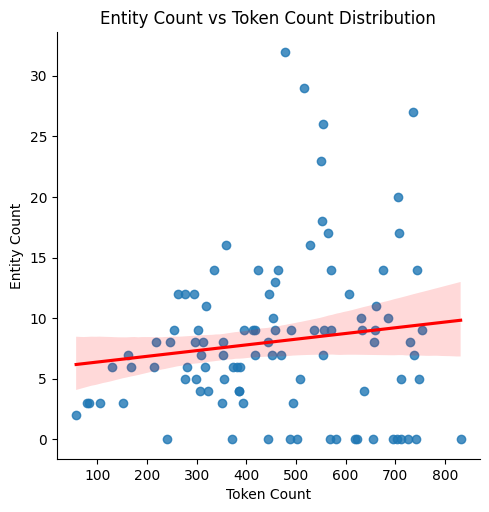

In [6]:
# 查询 Neo4j 以获取每个文档的实体计数和令牌计数
entity_dist = graph.query(    """
MATCH (d:Document)
RETURN d.text AS text, count {(d)-[:MENTIONS]->()} AS entity_count""")

# Convert the query result into a pandas DataFrame.
entity_dist_df = pd.DataFrame(entity_dist)
# Calculate the token count for each document's text.
entity_dist_df["token_count"] = [num_tokens_from_string(str(el)) for el in entity_dist_df["text"]]


# Create a scatter plot with a regression line to visualize the relationship.
# 创建带有回归线的散点图
#### Entity Count vs. Token Count
# Let's see if there is a correlation between the length of an article (token count) and the number of entities extracted from it.
# 图表显示了明显的正相关关系：随着文章 token 数量增加，提取的实体数量也呈现增长趋势。这一结果符合预期，验证了提取过程的逻辑合理性。
plt.figure(figsize=(8,10))
sns.lmplot(x="token_count", y="entity_count", data=entity_dist_df, line_kws={"color": "red"})
plt.title("Entity Count vs Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Entity Count")
plt.show()

#### Node Degree Distribution

Node degree is a measure of how many connections a node has. Analyzing its distribution helps us understand the overall structure of the graph. A power-law distribution (a long tail), which is common in real-world networks, would indicate the presence of a few highly connected hub nodes.

接下来分析节点度分布，以了解实体的连接程度。在真实世界的网络中，少数高度连接的节点（枢纽节点）是常见现象

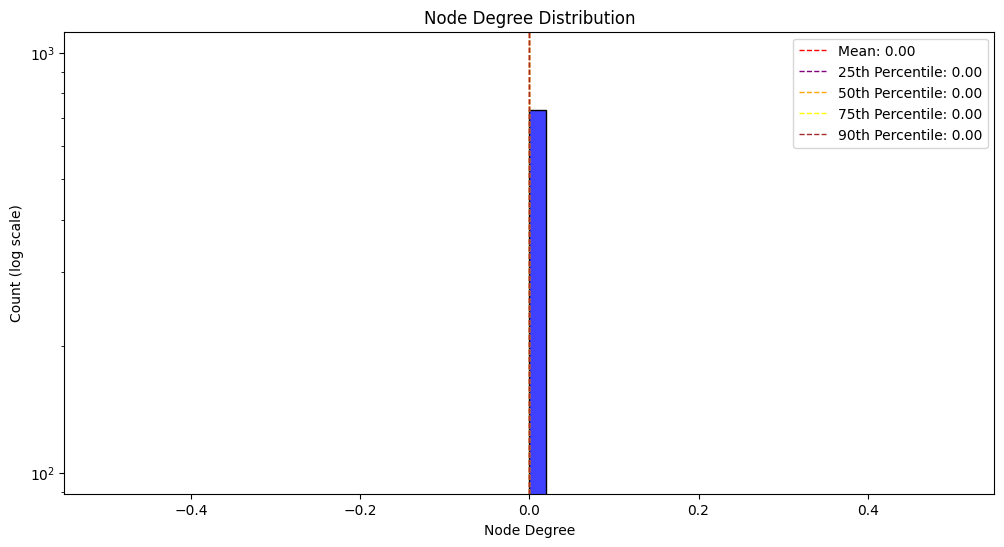

In [7]:
# Import numpy for numerical operations.
import numpy as np

# Query the graph to get the degree of each entity node.
# The `[:!MENTIONS]` syntax excludes the MENTIONS relationship from the count.
# 查询每个实体节点的度
degree_dist = graph.query("""MATCH (e:__Entity__)
RETURN count {(e)-[:!MENTIONS]-()} AS node_degree""")

degree_dist_df = pd.DataFrame.from_records(degree_dist)

# Calculate descriptive statistics for the node degrees.
# 计算统计数据
mean_degree = np.mean(degree_dist_df["node_degree"])
percentiles = np.percentile(degree_dist_df["node_degree"], [25, 50, 75, 90])

# Create a histogram to visualize the distribution.
# 使用对数尺度绘制直方图
'''
直方图呈现典型的"长尾"分布，这是知识图谱的标准特征。大多数实体具有较少的连接（低度值），而少数实体作为高连接度的枢纽存在。
具体分析显示，90% 的节点度数为 4，但最大度数达到 37。这表明诸如"USA"或"Microsoft"等实体可能在图中扮演中心节点的角色。
'''
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df["node_degree"], bins=50, kde=False, color="blue")
# Use a logarithmic scale on the y-axis to better visualize the long tail.
plt.yscale("log")
plt.title("Node Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("Count (log scale)")

# Add vertical lines for mean and percentiles to the plot.
plt.axvline(
    mean_degree,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {mean_degree:.2f}",
)
plt.axvline(
    percentiles[0],
    color="purple",
    linestyle="dashed",
    linewidth=1,
    label=f"25th Percentile: {percentiles[0]:.2f}",
)
plt.axvline(
    percentiles[1],
    color="orange",
    linestyle="dashed",
    linewidth=1,
    label=f"50th Percentile: {percentiles[1]:.2f}",
)
plt.axvline(
    percentiles[2],
    color="yellow",
    linestyle="dashed",
    linewidth=1,
    label=f"75th Percentile: {percentiles[2]:.2f}",
)
plt.axvline(
    percentiles[3],
    color="brown",
    linestyle="dashed",
    linewidth=1,
    label=f"90th Percentile: {percentiles[3]:.2f}",
)
plt.legend()
plt.show()

In [8]:
# Query to check the number of nodes and relationships with non-null descriptions.
# This helps assess the richness of the extracted information.
graph.query(
    """
MATCH (n:`__Entity__`)
RETURN "node" AS type,
       count(*) AS total_count,
       count(n.description) AS non_null_descriptions
UNION ALL
MATCH (n)-[r:!MENTIONS]->()
RETURN "relationship" AS type,
       count(*) AS total_count,
       count(r.description) AS non_null_descriptions
"""
)

Received notification from DBMS server: <GqlStatusObject gql_status='01N52', status_description='warn: property key does not exist. The property `description` does not exist. Verify that the spelling is correct.', position=<SummaryInputPosition line=5, column=16, offset=94>, raw_classification='UNRECOGNIZED', classification=<NotificationClassification.UNRECOGNIZED: 'UNRECOGNIZED'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'UNRECOGNIZED', '_severity': 'WARNING', '_position': {'offset': 94, 'line': 5, 'column': 16}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nMATCH (n:`__Entity__`)\nRETURN "node" AS type,\n       count(*) AS total_count,\n       count(n.description) AS non_null_descriptions\nUNION ALL\nMATCH (n)-[r:!MENTIONS]->()\nRETURN "relationship" AS type,\n       count(*) AS total_count,\n       count(r.description) AS non_null_descriptions\n'
Received notification from DBMS s

[{'type': 'node', 'total_count': 729, 'non_null_descriptions': 0}]

### Generating and Storing Node Embeddings

To perform more advanced graph algorithms like similarity search and community detection, we need to represent our nodes numerically. We'll generate vector embeddings for each entity node using our `llama3` embeddings model. These embeddings capture the semantic meaning of the node's ID and description. The `Neo4jVector` library simplifies this process, automatically generating embeddings for nodes that don't have them and storing them back in the database.

为了执行更高级的图算法，如相似性搜索和社区检测，即为了识别语义相似的实体（即使名称不同），需要为实体创建向量嵌入。使用llama3嵌入模型为每个实体节点的 id 和 description 生成嵌入并存储在图数据库中，这些嵌入捕获节点ID和description的语义含义。Neo4jVector库简化了这个过程，自动为没有嵌入的节点生成嵌入，并将它们存储回数据库中。

采用 Ollama 平台的 llama3 模型进行嵌入生成，使用 LangChain 的 Neo4jVector 组件处理相关流程。


In [10]:
# Import libraries for vector stores and the GDS library.
from langchain_community.vectorstores import Neo4jVector
from langchain_ollama import OllamaEmbeddings
from graphdatascience import GraphDataScience

# Initialize the GDS client, pointing to the correct database.
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "123qwe!@" # CHANGE THIS TO YOUR PASSWORD

# --- GDS 客户端初始化 ---
# 初始化 GraphDataScience 客户端以连接到 Neo4j 数据库。
# 它使用环境变量中的连接详细信息（URI、用户名、密码）。
gds = GraphDataScience(endpoint=os.environ["NEO4J_URI"],auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"]),)
# 为 GDS 操作设置特定数据库。
# gds.set_database(os.environ["DATABASE"])

# Initialize the embeddings model.
embeddings = OllamaEmbeddings(model="znbang/bge:large-en-v1.5-q8_0") # "Qwen3-4b"

# Initialize Neo4jVector from the existing graph.
# It will use the 'id' and 'description' properties to generate embeddings.
# The generated vectors will be stored in the 'embedding' property of the nodes.
# 初始化 Neo4jVector 实例以管理图中的嵌入
# 该操作遍历 Neo4j 中的所有 __Entity__ 节点，为其属性生成相应嵌入，并将结果存储在节点的 embedding 属性中。
vector = Neo4jVector.from_existing_graph(
    embeddings,
    node_label="__Entity__",
    text_node_properties=["id", "description"],
    embedding_node_property="embedding",)

print("Embedding update complete.")

Embedding update complete.


### Finding Similar Nodes with k-Nearest Neighbors (KNN)

With embeddings in place, we can find semantically similar nodes. We'll use the KNN algorithm in GDS to create `SIMILAR` relationships between nodes whose embeddings are close to each other (above a certain cosine similarity threshold). This helps enrich the graph by adding inferred connections.

基于生成的嵌入向量，现在可以采用 k-最近邻（kNN）算法识别向量空间中相互接近的节点。这是发现潜在重复或高度相关实体（例如"Man United"和"Manchester United"）的有效方法。

系统在嵌入相似性得分超过 0.95 的节点之间建立 SIMILAR 关系。

In [19]:
# Project the graph into the GDS in-memory catalog.
# This is a necessary step before running GDS algorithms.
# --- 内存图投影 ---
# 将图投影到内存中，以便 GDS 算法高效处理。
# 这个投影名为 'entities'。
G, result = gds.graph.project(
    "entities",                   # Name for the in-memory graph # 内存图的名称
    "__Entity__",                 # Node label to project # 要投影的节点标签
    "*",                          # Project all relationship types   # 投影所有关系类型
    nodeProperties=["embedding"]  # Include the embedding property # 为节点包含 'embedding' 属性
)

# Define a similarity threshold.
# --- 使用 kNN 计算相似性 ---
# 定义创建关系的相似性阈值。
similarity_threshold = 0.95

# Run the k-NN algorithm.
# This will create new 'SIMILAR' relationships in-memory for nodes with a cosine similarity
# score above the defined threshold.
# 使用 k-最近邻（kNN）算法查找相似节点。
# 这会通过添加新关系来"变异"内存图。
gds.knn.mutate(
    G,  # 要修改的内存图
    nodeProperties=["embedding"], # 用于相似性计算的属性
    mutateRelationshipType="SIMILAR", # 要创建的关系类型
    mutateProperty="score", # 新关系上存储相似性得分的属性
    similarityCutoff=similarity_threshold, # 过滤关系的阈值
)

ranIterations                                                            12
nodePairsConsidered                                                  322656
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                           317
mutateMillis                                                             12
postProcessingMillis                                                      0
nodesCompared                                                           729
relationshipsWritten                                                    154
similarityDistribution    {'p1': 0.9508628845214844, 'max': 0.9909782409...
configuration             {'topK': 10, 'maxIterations': 100, 'randomJoin...
Name: 0, dtype: object

### Entity Resolution: Merging Duplicate Nodes

LLM-based extraction isn't perfect and often creates duplicate entities (e.g., "Elon Musk" and "Elonmusk"). We can combine our graph structure with another LLM call to resolve these duplicates.

1.  **Candidate Identification**: We use a Cypher query to find potential duplicates. This query looks for nodes that are within the same community (identified by the Weakly Connected Components algorithm), have similar names (using Levenshtein distance via `apoc.text.distance`), and have a `SIMILAR` relationship.
2.  **LLM-based Merging**: We then pass these candidate groups to another BAML function (`ExtractDeDupe`) which asks the LLM to decide on a canonical, single name for each group.
3.  **Graph Refactoring**: Finally, we use the `apoc.refactor.mergeNodes` procedure in Neo4j to merge the identified duplicate nodes into a single node, cleaning up our graph.
4.  
kNN 算法识别出重复候选实体，但仅依靠文本相似性并不完美。可以通过寻找既语义相似又具有相近名称（低编辑距离）的实体来进一步优化结果。

查询这些候选实体，然后使用 LLM 做出最终的合并决策。

In [20]:
# Run the Weakly Connected Components (WCC) algorithm based on SIMILAR relationships.
# This assigns a community ID (`wcc`) to each node, which helps us scope our search for duplicates.
# The `.write()` mode persists this new property back to the Neo4j database.
gds.wcc.write(G, writeProperty="wcc", relationshipTypes=["SIMILAR"])

writeMillis                                                             54
nodePropertiesWritten                                                  729
componentCount                                                         667
componentDistribution    {'p1': 1, 'p5': 1, 'max': 7, 'p90': 1, 'p50': ...
postProcessingMillis                                                     7
preProcessingMillis                                                      0
computeMillis                                                           10
configuration            {'writeConcurrency': 4, 'seedProperty': None, ...
Name: 0, dtype: object

In [22]:
# Set the edit distance for finding similar strings (e.g., 'Market' vs 'Markets').
 # 基于社区和名称相似性查询潜在重复项
word_edit_distance = 3

# This complex Cypher query identifies groups of potential duplicate entities.
potential_duplicate_candidates = graph.query(
    # ... （来自笔记本的完整 Cypher 查询）...
    """MATCH (e:`__Entity__`)
    WHERE size(e.id) > 4 // longer than 4 characters
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    UNWIND nodes AS node
    // Add text distance
    WITH distinct
      [n IN nodes WHERE apoc.text.distance(toLower(node.id), toLower(n.id)) < $distance | n.id] AS intermediate_results
    WHERE size(intermediate_results) > 1
    WITH collect(intermediate_results) AS results
    // combine groups together if they share elements
    UNWIND range(0, size(results)-1, 1) as index
    WITH results, index, results[index] as result
    WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
            CASE WHEN index <> index2 AND
                size(apoc.coll.intersection(acc, results[index2])) > 0
                THEN apoc.coll.union(acc, results[index2])
                ELSE acc
            END
    )) as combinedResult
    WITH distinct(combinedResult) as combinedResult
    // extra filtering
    WITH collect(combinedResult) as allCombinedResults
    UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
    WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
    WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
        WHERE x <> combinedResultIndex
        AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
    )
    RETURN combinedResult
    """,
    params={"distance": word_edit_distance},
)

# Display the first 5 groups of potential duplicates found by the query.
# 让我们看看几个候选者
potential_duplicate_candidates[:5]

[{'combinedResult': ['Star Ocean The Second Story',
   'Star Ocean: The Second Story',
   'Star Ocean: The Second Story R']},
 {'combinedResult': ['Rpg Site', 'Rpgsite']},
 {'combinedResult': ['June 12, 2023', 'June 13, 2023', 'June 20, 2023']},
 {'combinedResult': ['Vivo X90', 'Vivo X90S']},
 {'combinedResult': ['Investor', 'Investors']}]

In [35]:
# This cell was commented out in the original notebook.
# It's used to reset BAML environment variables if they were set in a specific way,
# which is not necessary for this demonstration.
# from baml_client import reset_baml_env_vars
# import os
#
# reset_baml_env_vars(dict(os.environ))

# Import the prompts specific to the deduplication task.
from prompts.graphragprompts import system_prompt_duplicates, user_template

# Create the prompt template for this specific task.
extraction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt_duplicates,
        ),
        (
            "human",
            user_template,
        ),
    ]
)



# Define another BAML-powered chain for deduplicating entities.
# This will be used later in the notebook for entity resolution.
@chain
def get_entities(message):
    entities = b.ExtractDeDupe(graph=message.content)
    return entities.merged_results

# Assemble the chain for entity resolution by piping the prompt, LLM, and BAML parser.
extraction_chain = extraction_prompt | llm  #  | get_entities

# Test the deduplication chain with a sample list of entities.
entities = ["Star Ocean The Second Story R", "Star Ocean: The Second Story R"]
test1=extraction_chain.invoke(entities)
print(test1.content)

content="['Star Ocean: The Second Story R']" additional_kwargs={} response_metadata={'model': 'Qwen3-4b', 'created_at': '2026-01-03T14:17:30.6087766Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7669683800, 'load_duration': 78389900, 'prompt_eval_count': 193, 'prompt_eval_duration': 283912700, 'eval_count': 291, 'eval_duration': 7144526200, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run--5536a1fd-1d12-410d-bb8e-4caaf7e852f5-0' usage_metadata={'input_tokens': 193, 'output_tokens': 291, 'total_tokens': 484}


In [26]:
# A simple wrapper function to call the extraction chain.
def entity_resolution(entities: List[str]) -> Optional[List[str]]:
    return [extraction_chain.invoke(entities)]

# Test the function on the first list of candidates from our Cypher query.
entity_resolution(potential_duplicate_candidates[0]["combinedResult"])

NameError: name 'Optional' is not defined

In [47]:
# Import libraries for handling potential timeouts and retries.
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Optional
from tqdm import tqdm
import time

# Set the number of parallel workers.
MAX_WORKERS = 3

# Define a robust entity resolution function with retries to handle potential API failures.
def entity_resolution(
    entities: List[str], retries: int = 3, delay: float = 30.0
) -> Optional[List[str]]:
    for attempt in range(1, retries + 1):
        try:
            # Invoke the chain to get the canonical entity names.
            return [extraction_chain.invoke(entities)]
        except Exception as e:
            print(f"Attempt {attempt} failed for entities: {entities}, Error: {e}")
            if attempt < retries:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print("Max retries reached. Returning None.")
                return None

# Process all candidate lists in parallel to get the final merged entity lists.
merged_entities = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = [
        executor.submit(entity_resolution, el["combinedResult"])
        for el in potential_duplicate_candidates
    ]
    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        try:
            to_merge = future.result()
            if to_merge:
                merged_entities.extend(to_merge)
        except Exception as e:
            print(f"Error in future result: {e}")
            continue

Attempt 1 failed for entities: ['Vivo X90', 'Vivo X90S'], Error: name 'extraction_chain' is not defined
Retrying in 30.0 seconds...
Attempt 1 failed for entities: ['Telia', 'Tenaa', 'Tesla'], Error: name 'extraction_chain' is not defined
Retrying in 30.0 seconds...


Processing documents:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Attempt 2 failed for entities: ['Telia', 'Tenaa', 'Tesla'], Error: name 'extraction_chain' is not definedAttempt 2 failed for entities: ['Vivo X90', 'Vivo X90S'], Error: name 'extraction_chain' is not defined
Retrying in 30.0 seconds...

Retrying in 30.0 seconds...


Processing documents:   0%|                                                                                     | 0/2 [01:00<?, ?it/s]

Attempt 3 failed for entities: ['Telia', 'Tenaa', 'Tesla'], Error: name 'extraction_chain' is not definedAttempt 3 failed for entities: ['Vivo X90', 'Vivo X90S'], Error: name 'extraction_chain' is not defined
Max retries reached. Returning None.

Max retries reached. Returning None.


KeyboardInterrupt: 

In [ ]:
# Execute a Cypher query to merge the nodes in the database.
# It iterates through the lists of duplicates and merges them into a single node using APOC procedures.
graph.query(
    """
UNWIND $data AS candidates
CALL {
  WITH candidates
  MATCH (e:__Entity__) WHERE e.id IN candidates
  RETURN collect(e) AS nodes
}
CALL apoc.refactor.mergeNodes(nodes, {properties: {
    `.*`: 'discard'
}})
YIELD node
RETURN count(*)
""",
    params={"data": merged_entities},
)

### Hierarchical Community Detection with Leiden Algorithm

Community detection algorithms help uncover clusters of densely connected nodes in a graph. We will use the Leiden algorithm, a high-quality method that often produces better-defined communities than older algorithms like Louvain. By running it hierarchically, we can see how smaller communities merge into larger, more abstract ones at different levels of granularity.

In [ ]:
# Project the graph again, this time including relationship weights for the community detection algorithm.
G, result = gds.graph.project(
    "communities",  #  Name for the new in-memory graph
    "__Entity__",  #  Node projection
    {
        "_ALL_": {
            "type": "*",
            "orientation": "UNDIRECTED",
            "properties": {"weight": {"property": "*", "aggregation": "COUNT"}},
        }
    },
)

In [ ]:
# Run WCC stats to see the number of disconnected components before running Leiden.
wcc = gds.wcc.stats(G)
print(f"Component count: {wcc['componentCount']}")
print(f"Component distribution: {wcc['componentDistribution']}")

In [ ]:
# Run the Leiden algorithm to detect communities and write the results back to the database.
# `includeIntermediateCommunities=True` allows us to see the hierarchical structure.
gds.leiden.write(
    G,
    writeProperty="communities",
    includeIntermediateCommunities=True,
    relationshipWeightProperty="weight",
)

### Structuring Communities in the Graph

The Leiden algorithm stores community IDs as a list property on each node. The following queries transform this flat list into a hierarchical graph structure by creating `(__Community__)` nodes and linking them together, as well as linking entities to their respective communities.

In [47]:
# Create a uniqueness constraint on community IDs to ensure data integrity and improve query performance.
graph.query(
    "CREATE CONSTRAINT IF NOT EXISTS FOR (c:__Community__) REQUIRE c.id IS UNIQUE;"
)

[]

In [48]:
# This query creates the community nodes and their relationships.
graph.query(
    """
MATCH (e:`__Entity__`)
UNWIND range(0, size(e.communities) - 1 , 1) AS index
// Create the link from an entity to its lowest-level community
CALL {
  WITH e, index
  WHERE index = 0
  MERGE (c:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET c.level = index
  MERGE (e)-[:IN_COMMUNITY]->(c)
  RETURN count(*) AS count_0
}
// Create links between hierarchical community levels
CALL {
  WITH e, index
  WHERE index > 0
  MERGE (current:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET current.level = index
  MERGE (previous:`__Community__` {id: toString(index - 1) + '-' + toString(e.communities[index - 1])})
  ON CREATE SET previous.level = index - 1
  MERGE (previous)-[:IN_COMMUNITY]->(current)
  RETURN count(*) AS count_1
}
RETURN count(*)
"""
)

[{'count(*)': 7500}]

In [49]:
# This query calculates a 'community_rank' for each community based on how many unique documents are linked to it.
graph.query(
    """
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(:__Entity__)<-[:MENTIONS]-(d:Document)
WITH c, count(distinct d) AS rank
SET c.community_rank = rank;
"""
)

[]

### Analyzing Community Sizes

Finally, let's look at the size distribution of our detected communities at each level of the hierarchy. This helps us understand the structure of the topics within our document set, from very specific small clusters to broader thematic groups.


这一统计表格具有重要意义，展示了 Leiden 算法如何组织我们的 1,875 个实体。

在 Level 0 层级，系统识别出 858 个小规模、高内聚的社区，其中 90% 的社区包含 4 个或更少的成员。随着层级上升到 Level 3，算法将这些细粒度社区合

并为 732 个规模更大、覆盖面更广的社区。该层级的最大社区包含 77 个实体。

这种分层结构正是有效实施 GraphRAG 所需的理想架构。系统现在能够在不同抽象层级上执行信息检索操作。

In [50]:
# Query to get the size (number of entities) of each community at each level.
 # 查询每个级别每个社区的大小
community_size = graph.query(
    """
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(e:__Entity__)
WITH c, count(distinct e) AS entities
RETURN split(c.id, '-')[0] AS level, entities
"""
)
community_size_df = pd.DataFrame.from_records(community_size)

# Calculate percentile data for community sizes at each level.
percentiles_data = []
for level in sorted(community_size_df["level"].unique()):
    subset = community_size_df[community_size_df["level"] == level]["entities"]
    num_communities = len(subset)
    percentiles = np.percentile(subset, [25, 50, 75, 90, 99])
    percentiles_data.append(
        [
            level,
            num_communities,
            percentiles[0],
            percentiles[1],
            percentiles[2],
            percentiles[3],
            percentiles[4],
            max(subset),
        ]
    )

# Create a DataFrame to display the percentile statistics for easy comparison.
percentiles_df = pd.DataFrame(
    percentiles_data,
    columns=[
        "Level", "Number of communities", "25th Percentile", "50th Percentile",
        "75th Percentile", "90th Percentile", "99th Percentile", "Max",
    ],
)
# 打印处理的数据框
percentiles_df

,Level,Number of communities,25th Percentile,50th Percentile,75th Percentile,90th Percentile,99th Percentile,Max
0,0,858,1.0,1.0,2.0,4.0,10.43,37
1,1,749,1.0,1.0,2.0,5.0,18.52,77
2,2,734,1.0,1.0,2.0,5.0,27.67,77
3,3,732,1.0,1.0,2.0,5.0,27.69,77


In [52]:
# Query to retrieve detailed information about the communities, including their nodes and relationships.
# This data can be used for further summarization or visualization.
# 查询获取社区的详细信息，包括社区的节点和关系。该数据可用于进一步的汇总或可视化。
community_info = graph.query(
    """
MATCH (c:`__Community__`)<-[:IN_COMMUNITY*]-(e:__Entity__)
WHERE c.level IN [0,1]
WITH c, collect(e) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN c.id AS communityId,
       [n in nodes | {id: n.id, description: n.description, type: [el in labels(n) WHERE el <> '__Entity__'][0]}] AS nodes,
       [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id, description: r.description}] AS rels
"""
)

# Display information for the first community as an example.
community_info[:1]

[{'communityId': '0-1',
  'nodes': [{'id': 'Chevron',
    'description': 'Energy company',
    'type': 'Company'},
   {'id': 'O&G Sector', 'description': None, 'type': 'Industry'},
   {'id': 'Q2', 'description': None, 'type': 'Period of time'}],
  'rels': [{'start': 'Chevron',
    'description': None,
    'type': 'IS_A_PART_OF',
    'end': 'O&G Sector'},
   {'start': 'Q2',
    'description': 'risen sharply (~25%) during that same time frame',
    'type': 'EARNINGS_ESTIMATES',
    'end': 'Chevron'}]}]